---
---
# Use an ANN model to Predict the Wine's Sugar Content
### Goals:
1. Adapt code to predict sugar instead of quality.
2. Achieve as high of accuracy as possible for this problem.
### Notes:
- #### This differs from the previous projects, because now the model will predict sugar content instead of the subjective wine quality.
- #### Throughout this experiment, I'll be considering if the `quality` feature should be dropped. I would be interested to see if it harms or improves the model's performance.
- #### May still need to run a parametric experiment to figure out a good batch size. From previous projects I think batch sizes of 32 or 64 would be most stable.

In [633]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

### Data Processing
- #### Dropping quality from dataset because it is too subjective. It is up to human opinion, and that varies greatly from person to person.

In [634]:
# importing wine dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# removing outliers
data = data.drop(data[(data['total sulfur dioxide']>200)].index) # finds indices of rows where total sulfur dioxide > 200 and drops them

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000
mean,8.320163,0.528106,0.270463,2.531590,0.087513,15.847840,46.170946,0.996751,3.311490,0.658334,10.420632,5.634314
std,1.742123,0.178990,0.194384,1.395974,0.047076,10.438642,31.826498,0.001884,0.154115,0.169532,1.064260,0.806630
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997840,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,165.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [635]:
# selecting columns to normalize
selected_columns = data.keys()
selected_columns = selected_columns.drop('quality')
print(selected_columns)

# z-score all selected columns
data[selected_columns] = data[selected_columns].apply(stats.zscore)
data.describe()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,3.559388e-17,1.245786e-16,1.779694e-17,-9.788316e-17,-1.423755e-16,8.898469e-18,-5.339081e-17,-8.361001e-14,3.025479e-16,8.898469e-17,-5.695020e-16,5.634314
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,0.806630
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,3.000000
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,5.000000
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,6.000000
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,6.000000
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,8.000000


#### Partitioning Dataset and Creating DataLoader Objects

In [636]:
# dropping columns

selected_columns = selected_columns.drop('residual sugar')
print(selected_columns)


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol'],
      dtype='object')


In [637]:
# converting to tensors
torch_data = torch.tensor(data[selected_columns].values).float()
labels = torch.tensor(data['residual sugar'].values).float()

print(f"Size of torch_data dataset: {torch_data.size()}")

# converting to 1D array
#labels.unsqueeze(1) 
#print(f"Labels size = {labels.size()}")

labels = labels[:, None]
print(f"Labels size = {labels.size()}")

# partitioning data with train_test_split
training_set, tmp_set, training_labels, tmp_labels = train_test_split(torch_data, labels, train_size=0.8)

print(f"Size of tmp_dataset: {tmp_set.size()} and size of tmp_labels {tmp_labels.size()}")

dev_set, test_set, dev_labels, test_labels = train_test_split(tmp_set, tmp_labels, test_size=0.5) # 0.1, 0.1 split of overall dataset

# creating TensorDatasets
training_dataset = TensorDataset(training_set, training_labels)
dev_dataset = TensorDataset(dev_set, dev_labels)
test_dataset = TensorDataset(test_set, test_labels)

print(f"\nSize of training_dataset: {training_dataset.tensors[0].shape[0]}\nSize of dev_dataset: {dev_dataset.tensors[0].shape[0]} \nSize of test_dataset: {test_dataset.tensors[0].shape[0]}")

Size of torch_data dataset: torch.Size([1597, 10])
Labels size = torch.Size([1597, 1])
Size of tmp_dataset: torch.Size([320, 10]) and size of tmp_labels torch.Size([320, 1])

Size of training_dataset: 1277
Size of dev_dataset: 160 
Size of test_dataset: 160


In [638]:
# creates data loaders with specified batch size
def create_data_loaders(train_dataset, developer_dataset, testing_dataset, batch_size=32):    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    dev_loader = DataLoader(developer_dataset, batch_size=developer_dataset.tensors[0].shape[0], shuffle=False)
    test_loader = DataLoader(testing_dataset, batch_size=testing_dataset.tensors[0].shape[0], shuffle=False)
    
    return train_loader, dev_loader, test_loader

### Model Architecture

In [639]:
class ANN_wine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input_layer = nn.Linear(10,16) # may be 10,16 if quality is dropped

        # hidden layers
        self.batch_norm_1 = nn.BatchNorm1d(16) # batch normalization 1
        self.hidden_layer_1 = nn.Linear(16,64)
        
        self.batch_norm_2 = nn.BatchNorm1d(64) # batch normalization 2
        self.hidden_layer_2 = nn.Linear(64,64) # 64 is a good number here for some reason
        
        self.batch_norm_3 = nn.BatchNorm1d(64) # batch normalization 3
        self.hidden_layer_3 = nn.Linear(64,13)
        
        # output layer
        self.output_layer = nn.Linear(13,1)

    def forward(self, x, batch_norm=False):
        
        x = F.relu(self.input_layer(x)) # input z-score normalized data

        if batch_norm:
            x = self.batch_norm_1(x) # batch normalization
            x = self.hidden_layer_1(x) # hidden layer
            x = F.relu(x) # activation function

            x = self.batch_norm_2(x) # batch normalization
            x = self.hidden_layer_2(x) # hidden layer
            x = F.relu(x) # activation function

            x = self.batch_norm_3(x) # batch normalization
            x = self.hidden_layer_3(x) # hidden layer
            x = F.relu(x) # activation function

        else:
            x = F.relu(self.hidden_layer_1(x))
            x = F.relu(self.hidden_layer_2(x))
            x = F.relu(self.hidden_layer_3(x))

        return self.output_layer(x)

In [640]:
# function to create model
def create_ANN_wine_model(learning_rate):
    model = ANN_wine()

    # loss function
    loss_function = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_function, optimizer

#### Training Model
- In this case, will calculate training and dev set losses.
- The losses are computed because this is not a categorization problem.
    - The MSE loss function is being used instead of any binary cross entropy function.
    - In this case, a continuous numerical value is outputted from the model, not just a binary category.
- Accuracy could be computed by finding the correlation between the predicted value and the true value.
    - The correlation value would increase as the loss decreases.

In [641]:
def batch_train_model(number_of_epochs, model, loss_function, optimizer, train_loader, test_loader, batch_normalization=False):
    
    training_losses = torch.zeros(number_of_epochs)
    testing_losses = torch.zeros(number_of_epochs)

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        # enable training
        model.train()

        batch_loss = []
        
        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = model(batch, batch_normalization)
            loss = loss_function(y_hat, labels)

            # back propagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_losses[epoch_IDX] = np.mean(batch_loss)

        # disable training
        model.eval()

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        
        with torch.no_grad(): # disables gradient-related computations, appropriate when testing model
            y_hat = model(X_data, batch_normalization)

        # calculate testing accuracy
        testing_losses[epoch_IDX] = loss_function(y_hat, y_labels).item()

    return training_losses, testing_losses

#### Quick Sanity Check the Model and Training are set up correctly.

In [648]:
# test params
learning_rate = 0.001
number_epochs = 1000
batch_norm = True

model, losses_function, optimizer = create_ANN_wine_model(learning_rate)

train_ldr, dev_ldr, test_ldr = create_data_loaders(training_dataset, dev_dataset, test_dataset, batch_size=64)

# training model
training_losses, dev_losses = batch_train_model(number_epochs,
                                                model,
                                                losses_function,
                                                optimizer,
                                                train_ldr,
                                                dev_ldr,
                                                batch_normalization=batch_norm
                                                )

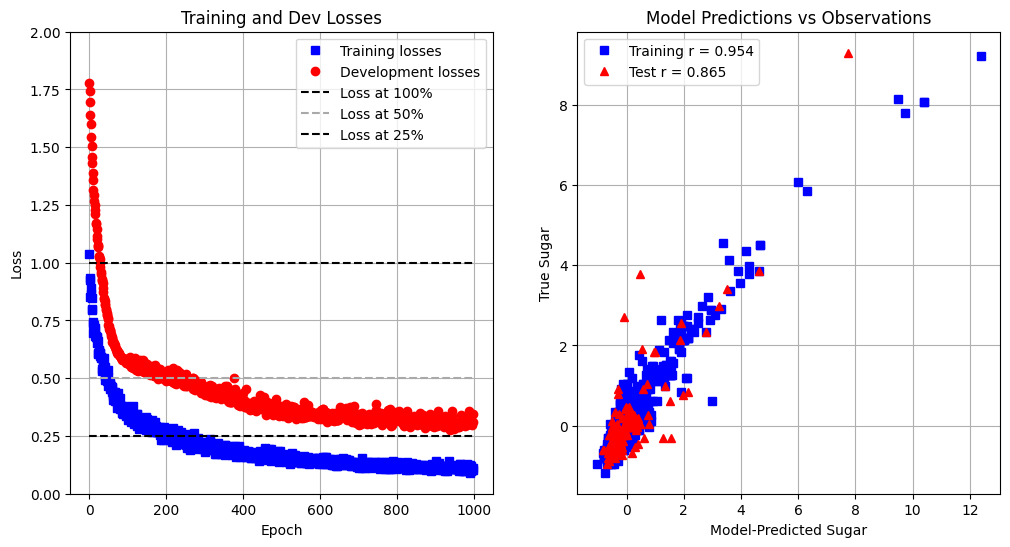

In [649]:
# plot results
fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].plot(training_losses, 'bs', label="Training losses")
ax[0].plot(dev_losses, 'ro', label="Development losses")
ax[0].set_title('Training and Dev Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0,2)
ax[0].plot([0, len(training_losses)], [1, 1], '--', color='black', label="Loss at 100%")
ax[0].plot([0, len(training_losses)], [0.5, 0.5], '--', color='darkgrey', label="Loss at 50%")
ax[0].plot([0, len(training_losses)], [0.25, 0.25], '--', color='black', label="Loss at 25%")
ax[0].grid()
ax[0].legend()

# plotting predictions vs real values
y_hat_train = model(training_set,batch_norm)
y_hat_test = model(test_set, batch_norm)

ax[1].plot(y_hat_train.detach(), training_labels,'bs')
ax[1].plot(y_hat_test.detach(), test_labels, 'r^')
ax[1].set_title('Model Predictions vs Observations')
ax[1].set_xlabel('Model-Predicted Sugar')
ax[1].set_ylabel('True Sugar')
ax[1].grid()

# calculating correlations between predictions and outputs
r_train = np.corrcoef(y_hat_train.detach().T, training_labels.T)[1,0]
r_test = np.corrcoef(y_hat_test.detach().T, test_labels.T)[1,0]
ax[1].legend([f"Training r = {r_train:.3f}", f"Test r = {r_test:.3f}"])

plt.show()

#### Interesting Notes
- There are some interesting problems with the consistency of this model. Part of it depends on how lucky the model is with the initial randomized weights, but I also feel like the sampling could use some work. 
- I'm not convinced that this dataset is evenly distributed, or that the samples taken are representative of the whole dataset. 
- It is especially a toss up whether or not the model can predict the higher sugar values correctly.